# Import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import datetime

import torch
from torch import nn, optim
from torchvision import datasets, transforms
import torch.nn.functional as F

In [2]:
device = ("cuda" if torch.cuda.is_available() else "cpu") # Use GPU or CPU for training

# Download the fashion-MNIST dataset

In [3]:
transform = transforms.Compose([
          transforms.Resize((32, 32)),
          transforms.ToTensor()
          ])

train_set = datasets.FashionMNIST('DATA_MNIST/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

test_set = datasets.FashionMNIST('DATA_MNIST/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)

train_data_size = len(train_set)
test_data_size = len(test_set)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting DATA_MNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to DATA_MNIST/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting DATA_MNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to DATA_MNIST/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting DATA_MNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to DATA_MNIST/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting DATA_MNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to DATA_MNIST/FashionMNIST/raw



In [4]:
# Check out the shape of the images
training_data = enumerate(trainloader)
batch_idx, (images, labels) = next(training_data)
print(images.shape) # Size of the image
print(labels.shape) # Size of the labels

torch.Size([64, 1, 32, 32])
torch.Size([64])


# Create the LeNet

In [5]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size=(2,2),stride=(2,2))
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=(5,5),stride=(1,1),padding=(0,0))
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=(5,5),stride=(1,1),padding=(0,0))
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=(5,5),stride=(1,1),padding=(0,0))
        self.linear1 = nn.Linear(120, 84)
        self.linear2 = nn.Linear(84, 10)
    
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x)) # num_examples x 120 x 1 x 1 --> num_examples x 120
        x = x.reshape(x.shape[0], -1)
        x = self.relu(self.linear1(x))
        x = self.linear2(x)
        return x

In [6]:
# Call the model
model = LeNet().to(device)
print(model)

LeNet(
  (relu): ReLU()
  (pool): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (linear1): Linear(in_features=120, out_features=84, bias=True)
  (linear2): Linear(in_features=84, out_features=10, bias=True)
)


In [10]:
# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.002)
criterion = nn.CrossEntropyLoss()

# The training phase

In [11]:
epochs = 50
train_loss, val_loss = [], []

for epoch in range(epochs):
   
    total_train_loss = 0
    total_val_loss = 0

    model.train()
    
    # training our model
    for idx, (image, label) in enumerate(trainloader):

        image, label = image.to(device), label.to(device)
        optimizer.zero_grad()
        pred = model(image)

        loss = criterion(pred, label)
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

    total_train_loss = total_train_loss / (idx + 1)
    train_loss.append(total_train_loss)
    
    # validating our model
    model.eval()
    total = 0
    for idx, (image, label) in enumerate(testloader):
        image, label = image.to(device), label.to(device)
        pred = model(image)
        loss = criterion(pred, label)
        total_val_loss += loss.item()

        pred = torch.nn.functional.softmax(pred, dim=1)
        for i, p in enumerate(pred):
            if label[i] == torch.max(p.data, 0)[1]:
                total = total + 1

    accuracy = total / test_data_size

    total_val_loss = total_val_loss / (idx + 1)
    val_loss.append(total_val_loss)

    if epoch % 5 == 0:
      print('\nEpoch: {}/{}, Train Loss: {:.4f}, Val Loss: {:.4f}, Val Acc: {:.4f}'.format(epoch, epochs, total_train_loss, total_val_loss, accuracy))


Epoch: 0/50, Train Loss: 0.2510, Val Loss: 0.3092, Val Acc: 0.8871

Epoch: 5/50, Train Loss: 0.2109, Val Loss: 0.3034, Val Acc: 0.8958

Epoch: 10/50, Train Loss: 0.1768, Val Loss: 0.3073, Val Acc: 0.9045

Epoch: 15/50, Train Loss: 0.1498, Val Loss: 0.3409, Val Acc: 0.8976

Epoch: 20/50, Train Loss: 0.1312, Val Loss: 0.3901, Val Acc: 0.8942

Epoch: 25/50, Train Loss: 0.1149, Val Loss: 0.4313, Val Acc: 0.8934

Epoch: 30/50, Train Loss: 0.1006, Val Loss: 0.4583, Val Acc: 0.8931

Epoch: 35/50, Train Loss: 0.0906, Val Loss: 0.5233, Val Acc: 0.8935

Epoch: 40/50, Train Loss: 0.0894, Val Loss: 0.5055, Val Acc: 0.8988

Epoch: 45/50, Train Loss: 0.0828, Val Loss: 0.5883, Val Acc: 0.8935


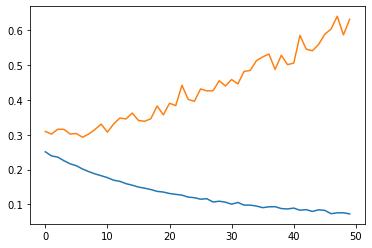

In [12]:
# Plot the train and validation losses
plt.plot(train_loss)
plt.plot(val_loss)

# Test the model

In [14]:
testiter = iter(testloader)
images, labels = next(testiter)

In [15]:
with torch.no_grad():
  images, labels = images.to(device), labels.to(device)
  preds = model(images)

In [16]:
# Extract all the images into a list using this one line for loop
images_np = [i.mean(dim=0).cpu().numpy() for i in images]

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

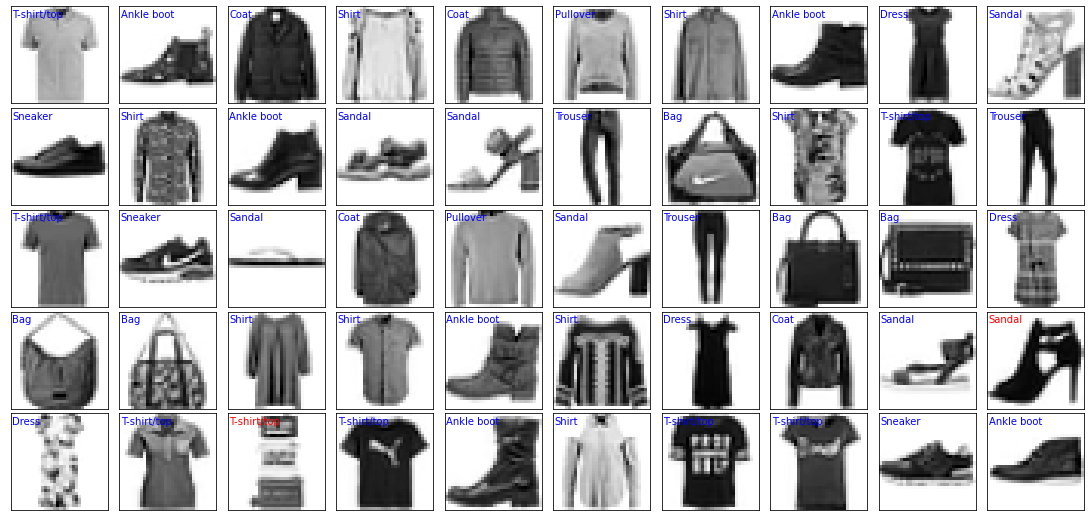

In [17]:
# Iterate through 50 images and plot them with their corresponding label
# Blue: if the guess is correct
# Red: if the guess is wrong
fig = plt.figure(figsize=(15, 7))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(50):
    ax = fig.add_subplot(5, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(images_np[i], cmap=plt.cm.gray_r, interpolation='nearest')

    if labels[i] == torch.max(preds[i], 0)[1]:
      ax.text(0, 3, class_names[torch.max(preds[i], 0)[1]], color='blue')
    else:
      ax.text(0, 3, class_names[torch.max(preds[i], 0)[1]], color='red')